# Data Processing

The data processing is divided into two stagaes
1. **Processing the simulation**: extracting the density, vortices & phase from the simulated fields
2. **Preparing for training**: downsampling, normalizing, adding noise etc.

## 1. Processing the Simulation

#### Libraries 📚🔽

In [1]:
import os
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
from scipy.constants import h, hbar, pi, k

# blurring
from scipy.ndimage import gaussian_filter

# propagation
from pygpe_oop.nonthermal.groundstate import Groundstate
from pygpe_oop.nonthermal.propagate import Propagate
from pygpe_oop.util.grid import Grid
from pygpe_oop.util.potentials import Potential

#### Constants

In [2]:
N = 280
DX = 2.5e-7
cloud_radius = 22.5e-6
vortex_mask_radius = 20e-6

mus = np.arange(1000, 1400, 50)
n_fields = 2500
m = mus.shape[0] * n_fields

### 1.1 Load Data

#### Change this to relative path in repo

In [3]:
data_path = "../qvortex-detection/single_layer/essential/data"

In [4]:
input_path = f"{data_path}/raw/280x280 temp 50 mu 1000-1350 fields 2500 8.8.24"
processed_path = f"{data_path}/raw/processed/280x280 temp 50 mu 1000-1350 fields 2500 18.9.24"

os.listdir(processed_path)

[]

### 1.2 Define Helper Functions

In [5]:
def get_field(input_path, mu, field_number):
    full_path = input_path + f"/mu{mu}/fields{field_number}.csv"

    field = np.loadtxt(full_path, delimiter=',')
    field = field[0].reshape((N,N))+1.0j*field[1].reshape((N,N)) # reshape to square

    return field 

In [6]:
@nb.njit(nb.float64[:,:](nb.complex128[:,:]))
def get_vortex_map(field):
    """Calculates the vortex locations from the phase of the field"""
    vmap = np.zeros((field.shape[0]-1, field.shape[1]-1))
    for i in range(field.shape[0]-1): 
        for j in range(field.shape[1]-1):
            phase1 = np.angle(np.exp(1.0j*(np.angle(field[i, j+1])-np.angle(field[i,j]))))
            phase2 = np.angle(np.exp(1.0j*(np.angle(field[i+1, j+1])-np.angle(field[i,j+1]))))
            phase3 = np.angle(np.exp(1.0j*(np.angle(field[i+1, j])-np.angle(field[i+1,j+1]))))
            phase4 = np.angle(np.exp(1.0j*(np.angle(field[i, j])-np.angle(field[i+1,j]))))
            circ = phase1+phase2+phase3+phase4
            if np.abs(circ-2*np.pi)<0.01: 
                vmap[i,j] = 1 
            elif np.abs(circ+2*np.pi)<0.01: 
                vmap[i,j] = -1
                
    return vmap

In [7]:
def get_vortex_pad(field):
    """Calculate the vortex map using `get_vortex_map(...)` and adding padding to recover the original N x N size."""
    vmap = get_vortex_map(field)
    vmap_pad = np.pad(vmap, pad_width=((0, 1), (0, 1)), constant_values=(0))

    return vmap_pad

In [8]:
grd_2d = Grid(2, dx=DX, dy=DX, Mx=N//2, My=N//2)
V_2d = Potential('round_box', grd_2d, wz=2*np.pi*1000, a=22.5e-6, h=10000)

def propagate_field_2d(field):
    """Propagates a field under time-of-flight expansion """
    Prop = Propagate(V_2d, psi0=field)
    field_prop = Prop.propagate(tTof = 5e-3, dt=5e-6, interactions=False)
    

    return field_prop

In [9]:
def mask_vmap(vmap, mask_radius=cloud_radius):
    """Mask a vortex map with a circular mask of radius mask_radius"""
    pixel_radius = int(mask_radius / DX)
    x_arange = (np.arange(N) - N / 2)
    y_arange = (np.arange(N) - N / 2)
    X_grid, Y_grid = np.meshgrid(x_arange, y_arange)
    R = np.sqrt(X_grid ** 2 + Y_grid ** 2)
    mask = (R <= pixel_radius)

    vmap_masked = np.multiply(vmap, mask)
    
    return vmap_masked

In [10]:
def gen_mask(mask_radius=cloud_radius):
    """Generates a circular mask of radius mask_radius"""
    pixel_radius = int(mask_radius / DX)
    x_arange = (np.arange(N) - N / 2)
    y_arange = (np.arange(N) - N / 2)
    X_grid, Y_grid = np.meshgrid(x_arange, y_arange)
    R = np.sqrt(X_grid ** 2 + Y_grid ** 2)
    mask = (R <= pixel_radius)

    return mask

In [11]:
def process_single_field(field, cg_sigma=2.6e-6, d_sigma=1.6e-6):
    """Process a single field from simulation output to density, vortices & phase."""
    # propagate
    field_prop = propagate_field_2d(field)

    # blurring
    field_blurred = gaussian_filter(field_prop, sigma=cg_sigma/DX)
    phase_blurred = np.angle(field_blurred)
    composite_field = np.abs(field_prop)*np.exp(1.0j*phase_blurred)

    # density
    density = np.abs(gaussian_filter(composite_field, sigma=d_sigma/DX))**2

    # vortices
    vortices = mask_vmap(get_vortex_pad(composite_field), mask_radius=vortex_mask_radius)
    
    # phase
    phase = np.angle(composite_field)
        
    return density, vortices, phase

### 1.3 Test a Single Field

In [12]:
field = get_field(input_path, mu=1000, field_number=2)
vmask = gen_mask(vortex_mask_radius)

density, vortices, phase = process_single_field(field)
points = np.where(vortices!=0)

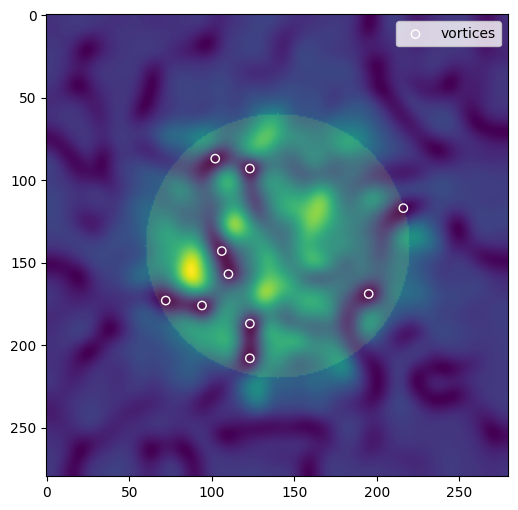

In [13]:
plt.figure(figsize=(6, 6))
plt.imshow(density)

plt.scatter(points[1], points[0],  marker='o', facecolors='none', edgecolors='white', alpha=1.0, label='vortices')
plt.imshow(vmask, alpha=0.1)
plt.legend()
plt.show()

### 1.4 Process all the fields

In [15]:
def process_fields(input_path, processed_path):
    """Master function to call all the above helper functions sequentially for every field in the raw data"""
    training_data_path = f"{processed_path}/training_data.npy"
    training_data = np.memmap(training_data_path, dtype='float64', mode='w+', shape=(3, m, N, N))
    
    for i in tqdm(range(m)):
        mu_index = i // n_fields
        field_number = i % n_fields
        
        # get field
        field = get_field(input_path, mu=mus[mu_index], field_number=field_number)

        # process field
        density, vortices, phase = process_single_field(field)

        # write to output
        training_data[0, i] = density
        training_data[1, i] = vortices
        training_data[2, i] = phase

    return training_data

In [16]:
training_data = process_fields(input_path, processed_path)
training_data.shape

  0%|          | 0/20000 [00:00<?, ?it/s]

(3, 20000, 280, 280)

## 2. Preparing for Training

- **Create output files on disk**: these will be the `X` and `Y` that we feed our CNN
- **Downsample**: oth the density and vortices will need to be downsampled by a factor of 4
- **Normalize**: normalization of density between [0, 1]
- **Add Noise**: add simple noise to the density
- **Take absolute value of vortices**: ignore difference between vortices and antivortices

#### Additional Libraries 📚🔽

In [17]:
from skimage.measure import block_reduce
from sklearn.cluster import AgglomerativeClustering

#### Additional Constants

In [18]:
chunk_size = 2500
X_scale = 4 # downsampling scale factor for density
Y_scale = 4 # downsampling scale factor for vortices
noise_strength = 0.03

### 2.1 Define output destination

In [19]:
output_path = f"{data_path}/training/70x70 temp 50 mu 1000-1350 fields 2500 18.9.24"
os.listdir(output_path)

[]

### 2.2 Define Helper Functions

In [20]:
def downsample(X_input, X):
    """Downsamples density images"""
    for i in tqdm(range(0, X_input.shape[0], chunk_size)):
        chunk = X_input[i:i+chunk_size]
        reduced = block_reduce(chunk, block_size=(1, X_scale, X_scale), func=np.mean)
        X[i:i+chunk_size] = reduced

In [21]:
def get_min_max(X):
    """Get the min and max densities within training data by iterating through chunks"""
    curr_min = float("inf")
    curr_max = float("-inf")
    
    for i in range(0, X.shape[0], chunk_size):
        chunk = X[i:i+chunk_size]
        curr_min = np.min([curr_min, np.min(chunk)])
        curr_max = np.max([curr_max, np.max(chunk)])
    
    return curr_min, curr_max

In [22]:
def normalize(X):
    """Normalizes X to the range [0,1]"""
    min_density, max_density = get_min_max(X)
    for i in tqdm(range(0, X.shape[0], chunk_size)):
        chunk = X[i:i+chunk_size]
        X[i:i+chunk_size] = (chunk - min_density) / (max_density - min_density)

In [23]:
def add_simple_noise(X, noise_strength: float):
    """Adds simple Gaussian white noise noise to X """
    for i in tqdm(range(X.shape[0])):
        noise = np.random.normal(size=X.shape[1:3], scale=noise_strength)
        X[i] += noise

In [24]:
def cluster(vortices):
    """Turn any pair of neighbouring vortices are turned into single vortices"""
    x, y = np.where(vortices!=0)
    if len(x) < 2:
        return vortices
        
    X = np.array([x,y]).T
    model = AgglomerativeClustering(n_clusters=None, distance_threshold=2)
    res = model.fit_predict(X)
    
    ures = np.unique(res)
    xc =[]
    yc = []
    for i in range(len(ures)): 
        inds = np.where(res==ures[i])
        xc.append(np.mean(x[inds]))
        yc.append(np.mean(y[inds]))

    vortices_cluster = np.zeros_like(vortices)
    for i in range(len(xc)):
        vortices_cluster[int(xc[i]), int(yc[i])] = 1.0

    return vortices_cluster

In [25]:
def process_Y(Y_input, Y):
    """Perform abs value, downsampling, and reshaping on vortices"""
    for i in tqdm(range(0, Y_input.shape[0], chunk_size)):
        # abs value
        chunk = np.abs(Y_input[i:i+chunk_size])

        # downsample
        reduced = block_reduce(chunk, block_size=(1, Y_scale, Y_scale), func=np.max)

        # cluster
        clustered = np.zeros_like(reduced)
        for j in range(chunk_size):
            clustered[j] = cluster(reduced[j])
        
        # reshape
        reshaped = np.reshape(clustered, newshape=(-1, N // Y_scale, N // Y_scale, 1))

        # write to output
        Y[i:i+chunk_size] = reshaped

### 2.3 Process all the images
#### `X`

In [26]:
X = np.memmap(f"{output_path}/X.npy", dtype='float64', mode='w+', shape=(m, N // X_scale, N // X_scale))

In [27]:
downsample(X_input=training_data[0], X=X)
normalize(X)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [28]:
add_simple_noise(X, noise_strength=noise_strength)
normalize(X)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

#### `Y`

In [29]:
Y = np.memmap(f"{output_path}/Y.npy", dtype='float64', mode='w+', shape=(m, N // Y_scale, N // Y_scale, 1))

In [31]:
process_Y(Y_input=training_data[1], Y=Y)

  0%|          | 0/8 [00:00<?, ?it/s]

#### `phase`

In [32]:
phase = np.memmap(f"{output_path}/phase.npy", dtype='float64', mode='w+', shape=(m, N // X_scale, N // X_scale))

In [33]:
downsample(X_input=training_data[2], X=phase)

  0%|          | 0/8 [00:00<?, ?it/s]

### 2.4. Check a training example

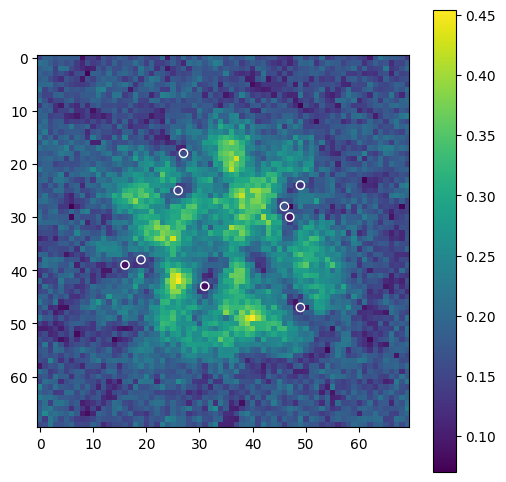

In [39]:
ind = 0

plt.figure(figsize=(6, 6))
plt.imshow(X[ind])
plt.colorbar()
points = np.where(Y[ind]!=0)
plt.scatter(points[1], points[0], marker='o', facecolors='none', edgecolors='white')
plt.show()

### 2.5 Vortex Number Statistics

In [40]:
print(f"Average vortex number: {np.mean(np.sum(Y, axis=(1,2,3)))}")
print(f"Min vortex number: {np.min(np.sum(Y, axis=(1,2,3)))}")
print(f"Max vortex number: {np.max(np.sum(Y, axis=(1,2,3)))}")

Average vortex number: 7.00945
Min vortex number: 0.0
Max vortex number: 22.0


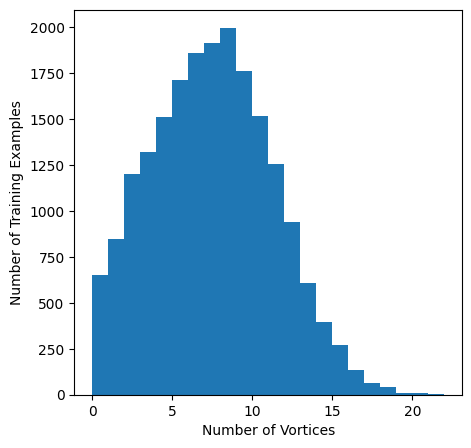

In [41]:
vortex_numbers = np.zeros(shape=(m))

for i in range(0, Y.shape[0], chunk_size):
    chunk = Y[i:i+chunk_size]
    chunk_sum = np.sum(chunk, axis=(1,2,3))
    vortex_numbers[i:i+chunk_size] = chunk_sum

fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(vortex_numbers, bins=int(np.max(vortex_numbers)) - int(np.min(vortex_numbers)))
plt.xlabel("Number of Vortices")
plt.ylabel("Number of Training Examples")
plt.show()